In [2]:
import os
import pathlib
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [4]:
data_dir = f"{os.getcwd()}/data/mini_speech_commands_extracted/mini_speech_commands"
commands = np.array(tf.io.gfile.listdir(f"{os.getcwd()}/data/mini_speech_commands_extracted/mini_speech_commands"))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['right' 'go' 'no' 'left' 'stop' 'up' 'down' 'yes']


In [5]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory = data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label name:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label name: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [6]:
train_ds.element_spec
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [ ]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)


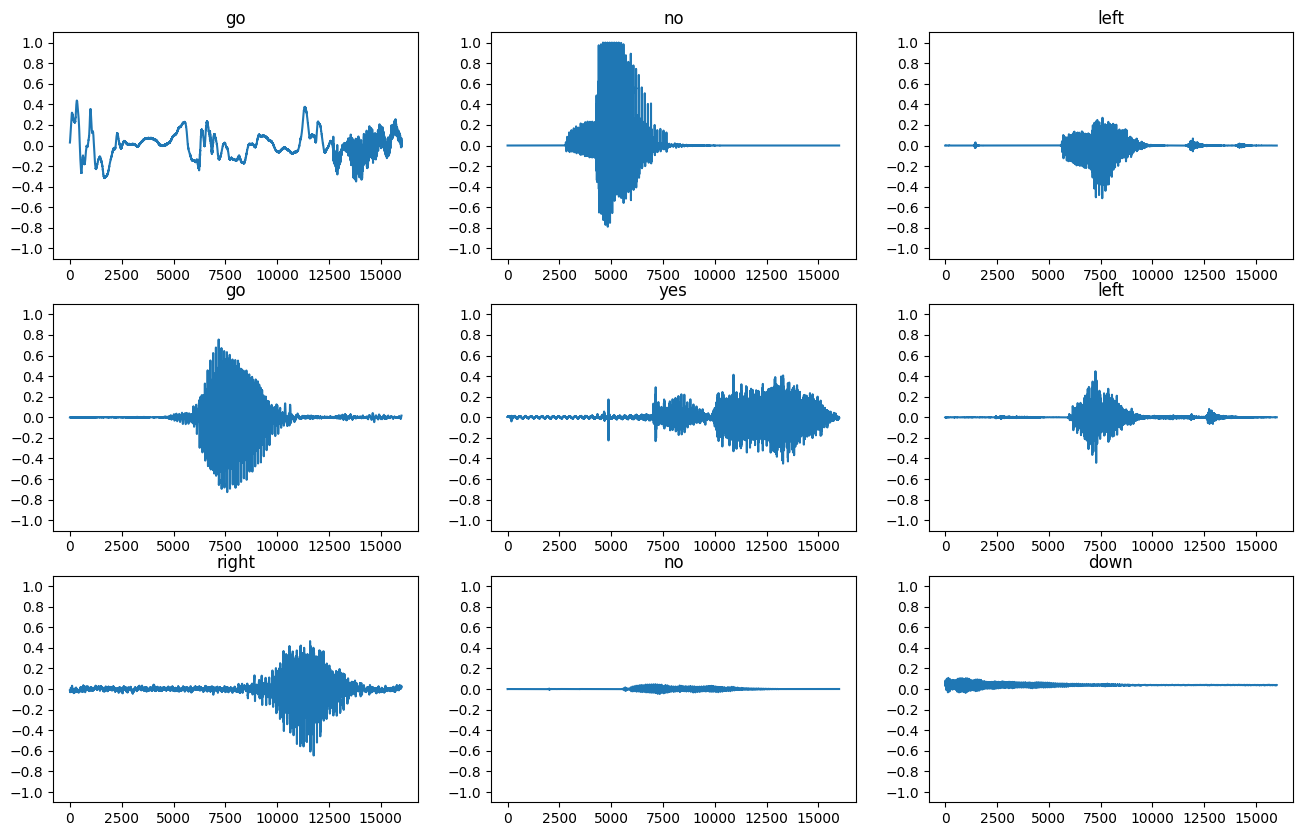

In [8]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [9]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [10]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

In [11]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)


In [13]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

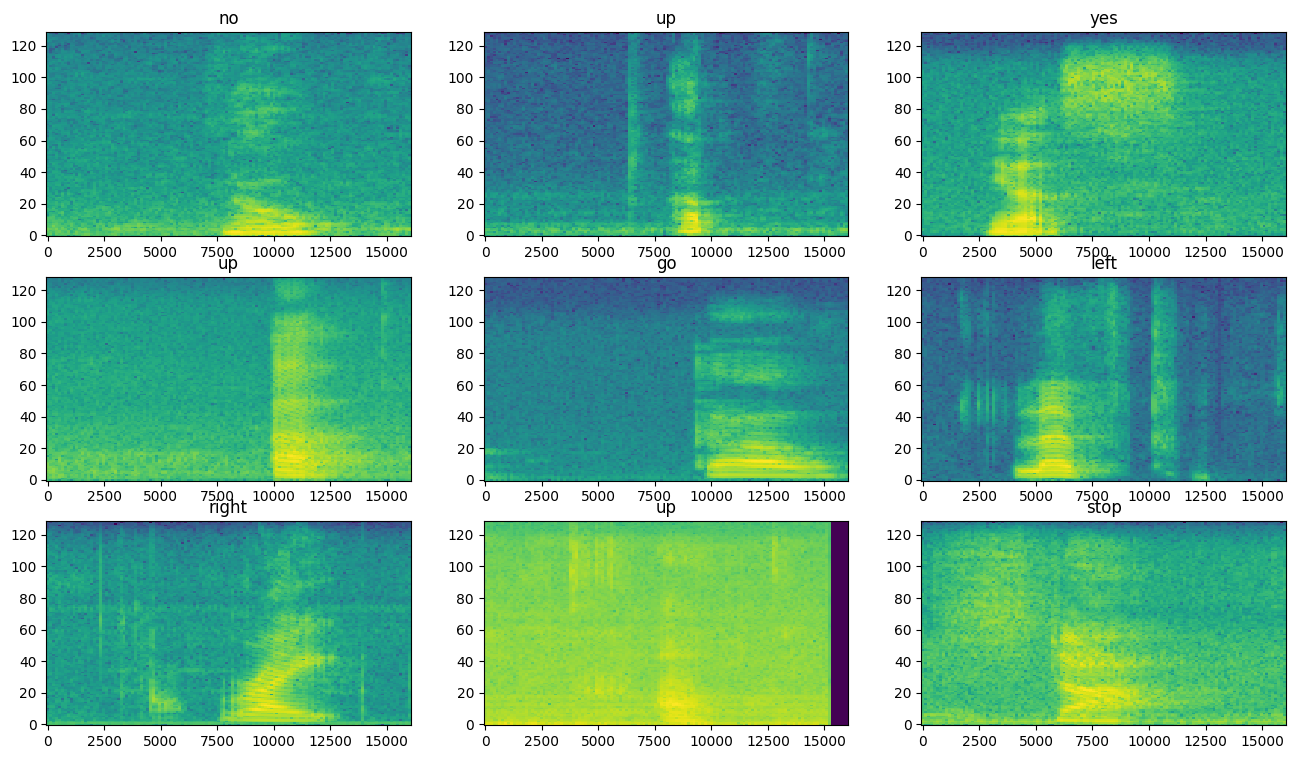

In [14]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [25]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

#softmax is not good for this function
def model_1(norm_layer, input_shape, num_labels):
    return models.Sequential([
        layers.Input(shape=input_shape),
        # Downsample the input.
        layers.Resizing(32, 32),
        # Normalize.
        norm_layer,
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels),
    ])
def model_2(norm_layer, input_shape, num_labels):
    return models.Sequential([
        layers.Input(shape=input_shape),
        # Downsample the input.
        layers.Resizing(32, 32),
        # Normalize.
        norm_layer,
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels),
    ])

model = model_1(norm_layer, input_shape, num_labels)

model.summary()

Input shape: (124, 129, 1)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_5 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_6 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,611 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.2738 - loss: 1.9185 - val_accuracy: 0.5938 - val_loss: 1.3022
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.5662 - loss: 1.2599 - val_accuracy: 0.7370 - val_loss: 0.9152
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.6788 - loss: 0.9125 - val_accuracy: 0.7682 - val_loss: 0.7525
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.7390 - loss: 0.7322 - val_accuracy: 0.7799 - val_loss: 0.6815
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.7781 - loss: 0.6466 - val_accuracy: 0.8086 - val_loss: 0.6409
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8061 - loss: 0.5418 - val_accuracy: 0.8229 - val_loss: 0.5694
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8355 - loss: 0.4636 - val_accuracy: 0.8268 - val_loss: 0.5478
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8495 - loss: 0.4341 - val_accu

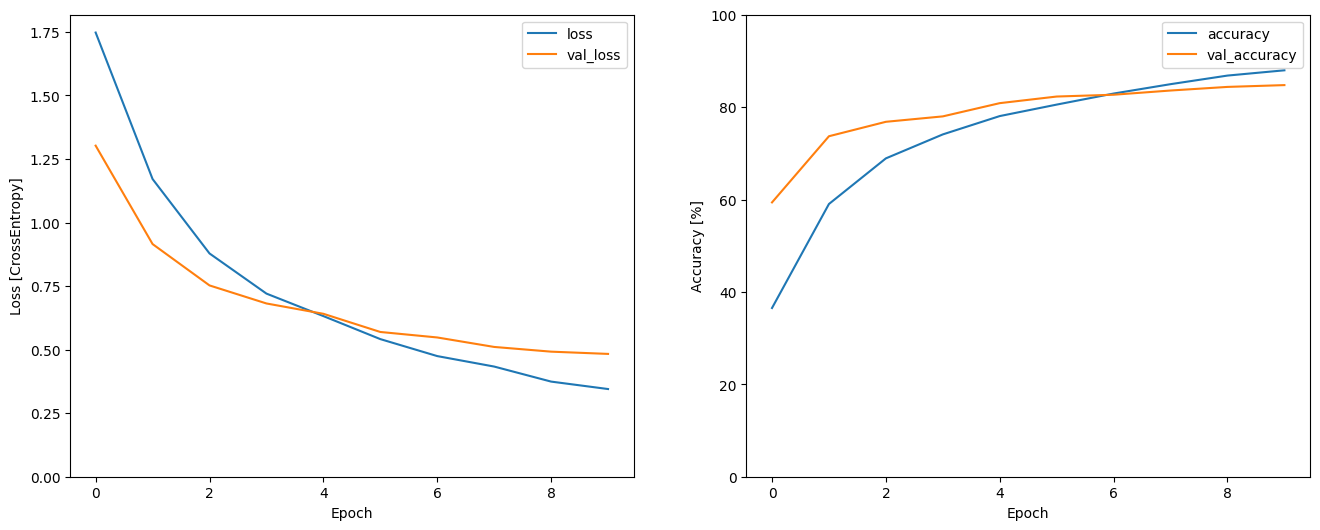

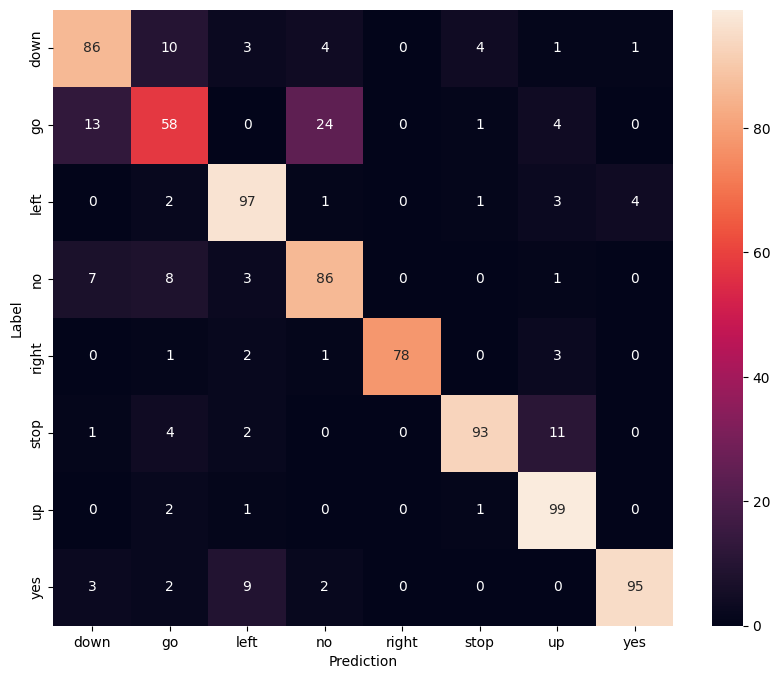

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

model.evaluate(test_spectrogram_ds, return_dict=True)
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [8]:
import speech_recognition as sr

# Initialize recognizer class (for recognizing the speech)
r = sr.Recognizer()

# Using Microphone as source
with sr.Microphone() as source:
    print("Speak now...")
    audio_text = r.listen(source)
    print(audio_text)
    print("Time over, thanks")
    
    try:
        print("Text: " + r.recognize_google(audio_text))
    except:
         print("Sorry, I did not get that")

Speak now...
Time over, thanks
Sorry, I did not get that


In [17]:
import speech_recognition as sr


# Initialize recognizer
recognizer = sr.Recognizer()




# Use the microphone as the audio source
with sr.Microphone() as source:
    print("Listening...")
    recognizer.adjust_for_ambient_noise(source)  # Adjust for background noise
     # Capture audio
    while True:
        try:
            # Listen for speech
            audio = recognizer.listen(source)  # Adjust timeout if needed
            
            # Convert speech to text
            text = recognizer.recognize_google(audio)
            print("You said:", text)
        
        except sr.UnknownValueError:
            print("Could not understand the audio")
        except sr.RequestError:
            print("Google Speech Recognition request failed (check internet)")
        except KeyboardInterrupt:
            print("\nStopping...")
            break  # Stop on Ctrl+C
        try: 
            print(model(nlp, text))
        except Exception as e:
            print(f"something bad has happened : {e}")
def model(nlp, text):
    #doc = nlp(text)
    # Match "SR-XX" or "SR XX" (with or without a space/dash)
    pattern = r'\b[A-Za-z]+\s*-\s*(\d\s*)+\b'
    match = re.search(pattern, text)
    if match:
        cleaned_match = re.sub(r'\s+', '', match.group())
        return cleaned_match  # Return matched ticket name
    return None


Listening...
You said: can you move Sr -2342
Sr-2342
You said: can you move Sr -2352
Sr-2352
You said: can you move Sr - 555 555
Sr-555555

Stopping...


In [5]:
import spacy
import os
import re
import subprocess
def loadModel(model): 
    try:
        subprocess.run(["python3", "-m", "spacy", "download", model]),
        nlp = spacy.load(model)  # Load small English model,
        return nlp,
    except:
        print(f"can not find model {model} loading default 'en_core_web_sm' model"),
        nlp = spacy.load('en_core_web_sm')
try:
    nlp = spacy.load('en_core_web_sm')
except Exception as e:
    print(f"downloading model")
    nlp = loadModel('en_core_web_sm')

from transformers import T5Tokenizer, T5ForConditionalGeneration

model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

def summarize_text(text, max_length=100):
    input_text = "summarize: " + text
    input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True)

    summary_ids = model.generate(
        input_ids,
        max_length=max_length,
        min_length=30,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

text = """
Artificial intelligence (AI) is the simulation of human intelligence processes by machines, especially computer systems. 
These processes include learning (the acquisition of information and rules for using the information), reasoning 
(using rules to reach approximate or definite conclusions), and self-correction. AI is being used in various 
applications, including speech recognition, natural language processing, and machine vision.
"""

summary = summarize_text(text)
print("Summary:", summary)


In [4]:
text = "The concept of artificial intelligence (AI) has rapidly evolved from theoretical musings to a tangible force shaping industries across the globe. While the potential benefits of AI are vast, ranging from medical breakthroughs to optimized logistics, ethical concerns regarding its development and deployment have become increasingly prominent. One key area of debate is the potential for AI to exacerbate existing social inequalities, as algorithms used in decision-making processes may inadvertently discriminate against marginalized groups based on biased data. Furthermore, the growing reliance on AI in critical sectors like healthcare and finance raises questions about accountability and transparency, as complex algorithms can be difficult to interpret and hold responsible in the event of errors. To mitigate these risks, experts advocate for the development of robust ethical frameworks that prioritize fairness, transparency, and human oversight in AI design. This includes actively addressing data bias, promoting diverse representation in AI development teams, and ensuring that AI systems are designed to be explainable and accountable to users. As the field of AI continues to advance, striking a balance between innovation and ethical considerations will be crucial to harness its full potential for the betterment of society."

summary = summarize_text(text)
print(f"summary: {summary}\n\n\nOriginal: {text}\n\noriginal length={len(text)}  summary length={len(summary)}")


summary: the concept of artificial intelligence (AI) has evolved from theoretical musings to a tangible force shaping industries across the globe. ethical concerns regarding its development and deployment have become increasingly prominent. the growing reliance on AI in critical sectors like healthcare and finance raises questions about accountability and transparency.


Original: The concept of artificial intelligence (AI) has rapidly evolved from theoretical musings to a tangible force shaping industries across the globe. While the potential benefits of AI are vast, ranging from medical breakthroughs to optimized logistics, ethical concerns regarding its development and deployment have become increasingly prominent. One key area of debate is the potential for AI to exacerbate existing social inequalities, as algorithms used in decision-making processes may inadvertently discriminate against marginalized groups based on biased data. Furthermore, the growing reliance on AI in critical 